In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as pt

View some attention kernels $\alpha(\mathbf{k}, \mathbf{q})$:


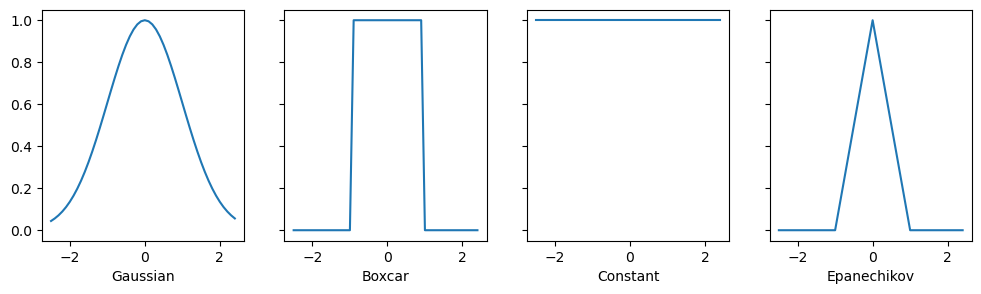

In [ ]:
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = pt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

pt.show()

Generate 40 training points with $y_i = 2\sin(x_i) + x_i + \epsilon, \epsilon \in N(0,1)$

Generate 50 test points with $y_i = 2\sin(x_i) + x_i$

In [3]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

Within regression setting, `x_train` and `y_train` are keys and values in our "database".

To predict `y_val` from `x_val`, let the query be a `x_val`.

Attention weights $W$ are calculated by our kernel from distances between `x_val` and `x_train` (normalization is implied):

$$W_{i,j} = \alpha(q_j, k_i)$$

where column $j$ contains the weight between query $j$ `x_val` and all keys `x_train`: $\alpha(q_j, k)$.



To make a prediction for $j$, just perform the attention pooling, where all `y_train`'s weighted sum are calculated:

$$\hat{y}_{j} = \sum_i \alpha(q_j, k_i) \cdot y_i$$

This is just taking the dot product between the entire `y_train` $\mathbf{y}$ and the column $j$ in $W$.

So if we put all $\hat{y}_{j}$ in a row vector $\hat{\mathbf{y}}$, then:

$$\hat{\mathbf{y}} = \mathbf{y} W$$

Note that we chose to place each query in a column for simplicity (so that output of all samples $\hat{y}$ would lie in a row vector),

but we could also choose the other way, placing a query in a row, then the complete output would be a column vector $\hat{\mathbf{y}} = W\mathbf{y}$.

This is more intuitive, especially when we encounter multi-dimensional data in the next chapter.

Below is the detailed implementation of the description above:

In [4]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # Calculate dists. Each column contains the dist between a query and all keys
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    
    # Compute attention weights W with kernel
    k = kernel(dists).type(torch.float32)
    
    # For each query (a column), normalize the weights on all keys
    attention_w = k / k.sum(0)
    
    # Multiply the entire y_train with matrix W
    y_hat = y_train@attention_w
    
    return y_hat, attention_w

Try different kernels.


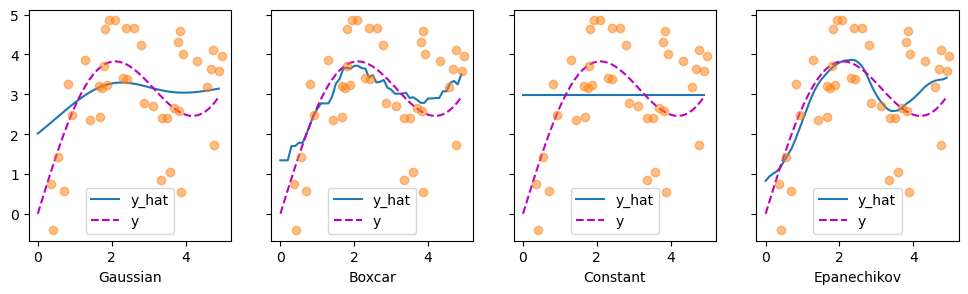

In [5]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = pt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)
        
plot(x_train, y_train, x_val, y_val, kernels, names)

Inspect the attention weights:


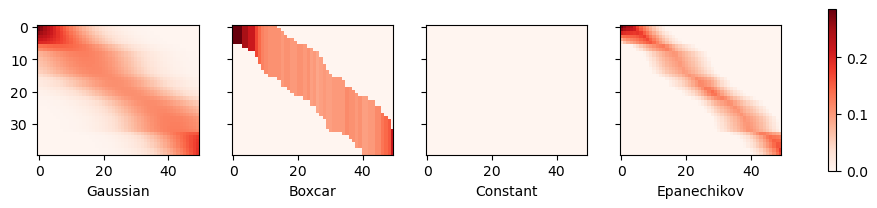

In [6]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)